In [1]:
import numpy as np
import pandas as pd



In [2]:
data = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")

In [3]:
data_np = data.to_numpy()
Y_train = data_np[:, 0]  # First column is the label
X_train = data_np[:, 1:]  # All other columns are features

# Normalize the data
X_train = X_train / 255.0

# Shuffle the data
def shuffle_data(X, Y):
    permutation = np.random.permutation(X.shape[0])
    return X[permutation], Y[permutation]

X_train, Y_train = shuffle_data(X_train, Y_train)

# Split into training and validation sets
val_size = int(0.1 * X_train.shape[0])  # 10% of the data
X_val, Y_val = X_train[:val_size], Y_train[:val_size]
X_train, Y_train = X_train[val_size:], Y_train[val_size:]

# Transpose X_train and X_val to match the expected shape for the neural network
X_train = X_train.T
X_val = X_val.T

# Number of unique classes
class_labels = data.iloc[:, 0]
unique_classes = class_labels.unique()
num_classes = unique_classes.size
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 10


In [4]:
def init_params(num_classes):
    W1 = np.random.randn(512, 784) * np.sqrt(2./784)
    b1 = np.zeros((512, 1))
    W2 = np.random.randn(256, 512) * np.sqrt(2./512)
    b2 = np.zeros((256, 1))
    W3 = np.random.randn(128, 256) * np.sqrt(2./256)
    b3 = np.zeros((128, 1))
    W4 = np.random.randn(64, 128) * np.sqrt(2./128)
    b4 = np.zeros((64, 1))
    W5 = np.random.randn(10, 64) * np.sqrt(2./64)
    b5 = np.zeros((10, 1))
    W6 = np.random.randn(num_classes, 10) * np.sqrt(2./10)
    b6 = np.zeros((num_classes, 1))
    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6

In [5]:
def LeakyReLU(Z, alpha=0.01):
    return np.maximum(alpha * Z, Z)

def LeakyReLU_deriv(Z, alpha=0.01):
    dZ = np.ones_like(Z)
    dZ[Z < 0] = alpha
    return dZ

def softmax(Z):
    Z -= np.max(Z, axis=0)
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A

def one_hot(Y, num_classes):
    one_hot_Y = np.zeros((Y.size, num_classes))
    one_hot_Y[np.arange(Y.size), Y.astype(int)] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def get_predictions(A):
    return np.argmax(A, axis=0)  # Takes the max value across classes to get predictions

def get_accuracy(predictions, labels):
    return np.mean(predictions == labels)  # Returns accuracy as a percentage of correct predictions

def dropout(A, keep_prob):
    D = np.random.rand(*A.shape) < keep_prob
    A *= D
    A /= keep_prob
    return A, D

def get_learning_rate(initial_lr, iteration, decay_rate=0.1):
    return initial_lr / (1 + decay_rate * iteration)  # Decays the learning rate as iterations increase



In [6]:
def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, X, keep_prob=1.0, is_training=True):
    Z1 = W1.dot(X) + b1
    A1 = LeakyReLU(Z1)
    if is_training:
        A1, D1 = dropout(A1, keep_prob)
    Z2 = W2.dot(A1) + b2
    A2 = LeakyReLU(Z2)
    if is_training:
        A2, D2 = dropout(A2, keep_prob)
    Z3 = W3.dot(A2) + b3
    A3 = LeakyReLU(Z3)
    if is_training:
        A3, D3 = dropout(A3, keep_prob)
    Z4 = W4.dot(A3) + b4
    A4 = LeakyReLU(Z4)
    if is_training:
        A4, D4 = dropout(A4, keep_prob)
    Z5 = W5.dot(A4) + b5
    A5 = LeakyReLU(Z5)
    if is_training:
        A5, D5 = dropout(A5, keep_prob)
    Z6 = W6.dot(A5) + b6
    A6 = softmax(Z6)
    cache = (Z1, A1, D1, Z2, A2, D2, Z3, A3, D3, Z4, A4, D4, Z5, A5, D5, Z6, A6) if is_training else (Z1, A1, Z2, A2, Z3, A3, Z4, A4, Z5, A5, Z6, A6)
    return A6, cache

In [7]:
def backward_prop(X, Y, cache, W1, W2, W3, W4, W5, W6, keep_prob, num_classes, lambd):
    m = Y.shape[0]
    (Z1, A1, D1, Z2, A2, D2, Z3, A3, D3, Z4, A4, D4, Z5, A5, D5, Z6, A6) = cache
    
    one_hot_Y = one_hot(Y, num_classes)
    dZ6 = A6 - one_hot_Y
    dW6 = 1/m * dZ6.dot(A5.T) + (lambd/m) * W6
    db6 = 1/m * np.sum(dZ6, axis=1, keepdims=True)
    
    dA5 = W6.T.dot(dZ6)
    dA5 *= D5
    dA5 /= keep_prob
    dZ5 = dA5 * LeakyReLU_deriv(Z5)
    dW5 = 1/m * dZ5.dot(A4.T) + (lambd/m) * W5
    db5 = 1/m * np.sum(dZ5, axis=1, keepdims=True)
    
    dA4 = W5.T.dot(dZ5)
    dA4 *= D4
    dA4 /= keep_prob
    dZ4 = dA4 * LeakyReLU_deriv(Z4)
    dW4 = 1/m * dZ4.dot(A3.T) + (lambd/m) * W4
    db4 = 1/m * np.sum(dZ4, axis=1, keepdims=True)
    
    dA3 = W4.T.dot(dZ4)
    dA3 *= D3
    dA3 /= keep_prob
    dZ3 = dA3 * LeakyReLU_deriv(Z3)
    dW3 = 1/m * dZ3.dot(A2.T) + (lambd/m) * W3
    db3 = 1/m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = W3.T.dot(dZ3)
    dA2 *= D2
    dA2 /= keep_prob
    dZ2 = dA2 * LeakyReLU_deriv(Z2)
    dW2 = 1/m * dZ2.dot(A1.T) + (lambd/m) * W2
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = W2.T.dot(dZ2)
    dA1 *= D1
    dA1 /= keep_prob
    dZ1 = dA1 * LeakyReLU_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T) + (lambd/m) * W1
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, dW6, db6


In [8]:
def gradient_descent(X_train, Y_train, X_val, Y_val, num_classes, 
                     initial_lr=0.005, iterations=400, batch_size=256, 
                     keep_prob=0.9, lambd=0.00005):
    W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = init_params(num_classes)
    m = X_train.shape[1]

    for i in range(iterations):
        permutation = np.random.permutation(m)
        X_train_shuffled = X_train[:, permutation]
        Y_train_shuffled = Y_train[permutation]

        for j in range(0, m, batch_size):
            end = j + batch_size
            X_batch = X_train_shuffled[:, j:end]
            Y_batch = Y_train_shuffled[j:end]

            A6, cache = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, X_batch, keep_prob)
            dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5, dW6, db6 = backward_prop(X_batch, Y_batch, cache, W1, W2, W3, W4, W5, W6, keep_prob, num_classes, lambd)

            lr = get_learning_rate(initial_lr, i)
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2
            W3 -= lr * dW3
            b3 -= lr * db3
            W4 -= lr * dW4
            b4 -= lr * db4
            W5 -= lr * dW5
            b5 -= lr * db5
            W6 -= lr * dW6
            b6 -= lr * db6

        if i % 10 == 0:
            train_predictions = get_predictions(forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, X_train, is_training=False)[0])
            val_predictions = get_predictions(forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, X_val, is_training=False)[0])
            train_accuracy = get_accuracy(train_predictions, Y_train)
            val_accuracy = get_accuracy(val_predictions, Y_val)
            print(f"Iteration {i}: Train Accuracy = {train_accuracy * 100:.2f}%, Validation Accuracy = {val_accuracy * 100:.2f}%")

    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6

In [9]:
def get_learning_rate(initial_lr, iteration, decay_rate=0.1):
    return initial_lr / (1 + decay_rate * iteration)

In [10]:
# Training the neural network
W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6 = gradient_descent(
    X_train, Y_train, X_val, Y_val, num_classes, 
    initial_lr=0.005, iterations=1200, batch_size=256, 
    keep_prob=0.9, lambd=0.00005
)

Iteration 0: Train Accuracy = 43.36%, Validation Accuracy = 42.82%
Iteration 10: Train Accuracy = 76.85%, Validation Accuracy = 77.78%
Iteration 20: Train Accuracy = 79.49%, Validation Accuracy = 79.90%
Iteration 30: Train Accuracy = 80.91%, Validation Accuracy = 81.12%
Iteration 40: Train Accuracy = 81.53%, Validation Accuracy = 81.67%
Iteration 50: Train Accuracy = 82.06%, Validation Accuracy = 82.18%
Iteration 60: Train Accuracy = 82.37%, Validation Accuracy = 82.48%
Iteration 70: Train Accuracy = 82.64%, Validation Accuracy = 82.60%
Iteration 80: Train Accuracy = 82.88%, Validation Accuracy = 82.92%
Iteration 90: Train Accuracy = 83.00%, Validation Accuracy = 83.27%
Iteration 100: Train Accuracy = 83.16%, Validation Accuracy = 83.37%
Iteration 110: Train Accuracy = 83.34%, Validation Accuracy = 83.58%
Iteration 120: Train Accuracy = 83.50%, Validation Accuracy = 83.65%
Iteration 130: Train Accuracy = 83.57%, Validation Accuracy = 83.75%
Iteration 140: Train Accuracy = 83.72%, Valid

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the test data
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')
test_data_np = test_data.to_numpy()
Y_test = test_data_np[:, 0]
X_test = test_data_np[:, 1:] / 255.0
X_test = X_test.T

# Get predictions on the test set
test_predictions = get_predictions(forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, W6, b6, X_test, is_training=False)[0])

# Calculate metrics
test_accuracy = accuracy_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions, average='weighted')
test_recall = recall_score(Y_test, test_predictions, average='weighted')
test_f1 = f1_score(Y_test, test_predictions, average='weighted')
test_conf_matrix = confusion_matrix(Y_test, test_predictions)

# Print metrics
print(f"Test Accuracy = {test_accuracy * 100:.2f}%")
print(f"Test Precision = {test_precision:.2f}")
print(f"Test Recall = {test_recall:.2f}")
print(f"Test F1 Score = {test_f1:.2f}")
print(f"Confusion Matrix:\n{test_conf_matrix}")


Test Accuracy = 86.02%
Test Precision = 0.86
Test Recall = 0.86
Test F1 Score = 0.86
Confusion Matrix:
[[847   4  15  32   0   2  89   0  11   0]
 [  3 971   6  13   1   0   5   0   0   1]
 [ 12   0 786  12 119   0  65   0   6   0]
 [ 36  17  16 885  26   0  15   0   4   1]
 [  2   1  76  27 810   0  82   0   2   0]
 [  1   0   0   1   0 923   0  42   4  29]
 [203   3 112  23  75   0 572   0  12   0]
 [  0   0   0   0   0  37   0 889   0  74]
 [  2   0   9   2   4   4  12   4 962   1]
 [  0   0   0   0   0   9   0  34   0 957]]



Model Performance Metrics:
------------------------------
Test Accuracy  = 86.02%
Test Precision = 0.8590
Test Recall    = 0.8602
Test F1 Score  = 0.8588

Neural Network Architecture and Parameter Breakdown:
------------------------------------------------------------
Layer      Shape           Trainable Parameters      Activation     
------------------------------------------------------------
Input      (784,)          0                         -              
W1         (512, 784)      401408                    LeakyReLU      
b1         (512, 1)        512                                      
W2         (256, 512)      131072                    LeakyReLU      
b2         (256, 1)        256                                      
W3         (128, 256)      32768                     LeakyReLU      
b3         (128, 1)        128                                      
W4         (64, 128)       8192                      LeakyReLU      
b4         (64, 1)         64                   

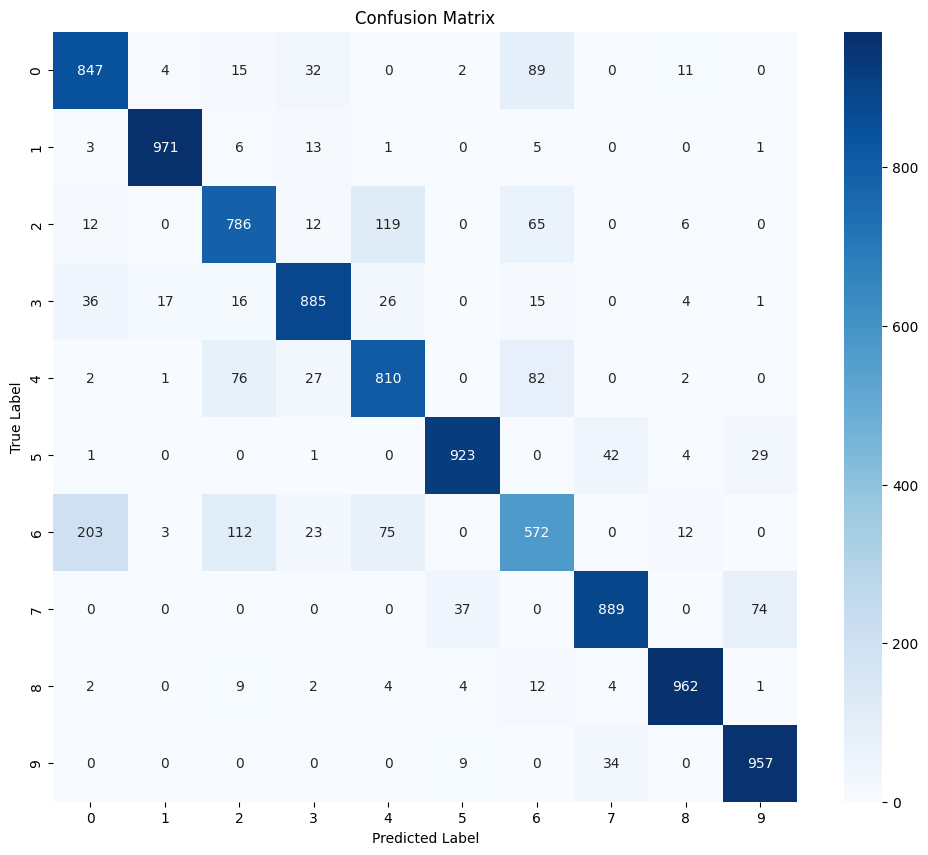

In [12]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Calculate metrics
test_accuracy = accuracy_score(Y_test, test_predictions)
test_precision = precision_score(Y_test, test_predictions, average='weighted')
test_recall = recall_score(Y_test, test_predictions, average='weighted')
test_f1 = f1_score(Y_test, test_predictions, average='weighted')
test_conf_matrix = confusion_matrix(Y_test, test_predictions)

# Print metrics
print("\nModel Performance Metrics:")
print("-" * 30)
print(f"Test Accuracy  = {test_accuracy * 100:.2f}%")
print(f"Test Precision = {test_precision:.4f}")
print(f"Test Recall    = {test_recall:.4f}")
print(f"Test F1 Score  = {test_f1:.4f}")

# Calculate number of parameters
def count_parameters(W, b):
    return W.size + b.size

total_params = count_parameters(W1, b1) + count_parameters(W2, b2) + count_parameters(W3, b3) + \
               count_parameters(W4, b4) + count_parameters(W5, b5) + count_parameters(W6, b6)

# Create a table of parameters
print("\nNeural Network Architecture and Parameter Breakdown:")
print("-" * 60)
print(f"{'Layer':<10} {'Shape':<15} {'Trainable Parameters':<25} {'Activation':<15}")
print("-" * 60)
print(f"{'Input':<10} {'(784,)':<15} {'0':<25} {'-':<15}")
print(f"{'W1':<10} {str(W1.shape):<15} {W1.size:<25} {'LeakyReLU':<15}")
print(f"{'b1':<10} {str(b1.shape):<15} {b1.size:<25} {'':<15}")
print(f"{'W2':<10} {str(W2.shape):<15} {W2.size:<25} {'LeakyReLU':<15}")
print(f"{'b2':<10} {str(b2.shape):<15} {b2.size:<25} {'':<15}")
print(f"{'W3':<10} {str(W3.shape):<15} {W3.size:<25} {'LeakyReLU':<15}")
print(f"{'b3':<10} {str(b3.shape):<15} {b3.size:<25} {'':<15}")
print(f"{'W4':<10} {str(W4.shape):<15} {W4.size:<25} {'LeakyReLU':<15}")
print(f"{'b4':<10} {str(b4.shape):<15} {b4.size:<25} {'':<15}")
print(f"{'W5':<10} {str(W5.shape):<15} {W5.size:<25} {'LeakyReLU':<15}")
print(f"{'b5':<10} {str(b5.shape):<15} {b5.size:<25} {'':<15}")
print(f"{'W6':<10} {str(W6.shape):<15} {W6.size:<25} {'Softmax':<15}")
print(f"{'b6':<10} {str(b6.shape):<15} {b6.size:<25} {'':<15}")
print("-" * 60)
print(f"{'Total':<10} {'':<15} {total_params:<25}")
print(f"\nTotal trainable parameters: {total_params}")
print(f"Total non-trainable parameters: 0")


# Visualizations
plt.figure(figsize=(12, 10))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()